In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cs5228-2021s1/Xtest.csv
/kaggle/input/cs5228-2021s1/sample_output.csv
/kaggle/input/cs5228-2021s1/dataset_info.docx
/kaggle/input/cs5228-2021s1/Ytrain.csv
/kaggle/input/cs5228-2021s1/Xtrain.csv


In [2]:
from kaggle_datasets import KaggleDatasets
import os

from scipy.stats import uniform, randint

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from category_encoders import TargetEncoder

# data manipulation
import pandas as pd
import numpy as np
from time import strptime

# visualization
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline

# model training
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV

# model evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error

# classifiers
from sklearn.neighbors import KNeighborsClassifier # KNN
from sklearn.linear_model import LogisticRegression # logistic regression
from sklearn.tree import DecisionTreeClassifier # decision Tree
from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
import lightgbm as lgbm
import catboost as cb

# ignore warnings
import warnings
warnings.filterwarnings('ignore')
SEED = 42
np.random.seed(SEED)
GCS_DS_PATH = KaggleDatasets().get_gcs_path()
Xtrain_PATH = "Xtrain.csv" 
Ytrain_PATH = "Ytrain.csv" 
Xtest_PATH = "Xtest.csv"

code structure:
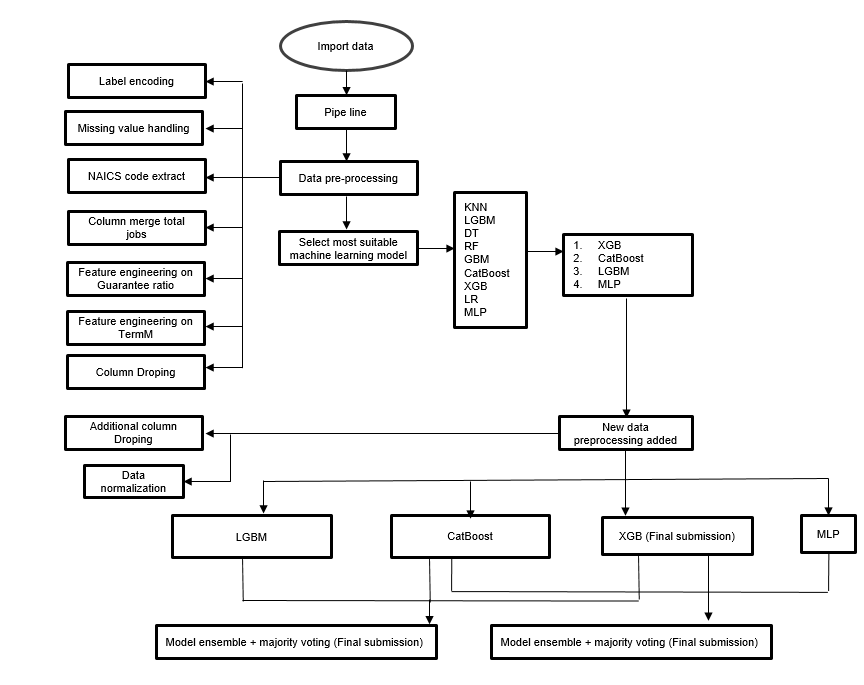

# <font color='gris'> Continuous Value transformation  </font>
<font color='black'> datetime and currency transformation</font>

In [3]:
#date time conversion
def date_to_ym(date):   
    if not isinstance(date, str):
        return 0
    st = strptime(date, '%d-%b-%y')
    return st.tm_year*100 + (st.tm_mon-1)//3

#currency conversion
def currency_to_float(currency):
    return float(''.join(currency.strip('$ ').split(',')))

# <font color='gris'> Categorical Value transformation  </font>
<font color='black'> target encoding</font>

In [4]:
def encode_get_le(df):
    # Target encodings
    city_le = TargetEncoder()
    df['City'] = city_le.fit_transform(df['City'], df['Term'])
    
    state_le = TargetEncoder()
    df['State'] = state_le.fit_transform(df['State'], df['Term'])
    
    bank_le = TargetEncoder()
    df['Bank'] = bank_le.fit_transform(df['Bank'], df['Term'])
    
    bank_state_le = TargetEncoder()
    df['BankState'] = bank_state_le.fit_transform(df['BankState'], df['Term'])
    
    revlinecr_le = TargetEncoder()
    df['RevLineCr'] = revlinecr_le.fit_transform(df['RevLineCr'], df['Term'])
    
    lowdoc_le = TargetEncoder()
    df['LowDoc'] = lowdoc_le.fit_transform(df['LowDoc'], df['Term'])
    
    return city_le, state_le, bank_le, bank_state_le, revlinecr_le, lowdoc_le

def encode_with_le(df, *args):
    city_le, state_le, bank_le, bank_state_le, revlinecr_le, lowdoc_le = args
    
    df['City'] = city_le.transform(df['City'])

    df['State'] = state_le.transform(df['State'])
    
    df['Bank'] = bank_le.transform(df['Bank'])
    
    df['BankState'] = bank_state_le.transform(df['BankState'])
    
    df['RevLineCr'] = revlinecr_le.transform(df['RevLineCr'])
    
    df['LowDoc'] = lowdoc_le.transform(df['LowDoc'])
    
    return df

# <font color='gris'> Data cleanning and transfomation  </font>
<font color='black'> Fill in missing value for categorical value</font>

In [5]:
def fill_nan_categorical(df):
    
    df['LowDoc'][pd.isnull(df['LowDoc'])]  = 'NaN'
    
    df['RevLineCr'][pd.isnull(df['RevLineCr'])]  = 'NaN'
    
    df['BankState'][pd.isnull(df['BankState'])]  = 'NaN'
    
    df['Bank'][pd.isnull(df['Bank'])]  = 'NaN'
    
    return df

<font color='black'> Fill in missing value for continuous value</font>

In [6]:
def fill_nan_continuous(df):
    
    df.interpolate(inplace=True)
    
    df.reset_index(inplace=True)
    
    return df

<font color='black'> Data transformation</font>

In [7]:
def transform(df,finetune = False):

    df['Zip'] = (df['Zip']//100)
    
    df['ApprovalYM'] = df['ApprovalDate'].apply(date_to_ym)
    
    df.replace({'ApprovalFY':'1976A'}, '1976', inplace=True)
    
    df['ApprovalFY'] = df['ApprovalFY'].astype(int)

    df['TermM'] = df['Term']%12

    df.replace({'NewExist':2}, 0, inplace=True)
    
    df['NewExist'] = df['NewExist'].astype(int)
    
    df['CreateJob'] = df['CreateJob'].astype(pd.SparseDtype(int, fill_value=0))
    
    df['RetainedJob'] = df['RetainedJob'].astype(pd.SparseDtype(int, fill_value=0))
    
    df['NoJob'] = df['CreateJob'] + df['RetainedJob']
    
    df['DisbursementYM'] = df['DisbursementDate'].apply(date_to_ym)

    df['DisbursementGross'] = df['DisbursementGross'].apply(currency_to_float)

    df['GrAppv'] = df['GrAppv'].apply(currency_to_float)
    
    df['SBA_Appv'] = df['SBA_Appv'].apply(currency_to_float)
    
    df['GuaranteedRatio'] = df['SBA_Appv']/df['GrAppv']
    
    if not finetune:
        
        df['NAICS'] = df['NAICS'].apply(lambda NAICS: int(str(NAICS)[:2]))
        
        df.drop(columns=['Id', 'Name','ApprovalDate',
                 'CreateJob', 'RetainedJob', 
                 'DisbursementDate', 'GrAppv', 
                 'SBA_Appv', 'BalanceGross'],
        inplace=True)

    else:
        
        df.drop(columns=['Id', 'Name','ApprovalDate',
                 'CreateJob', 'RetainedJob', 
                 'DisbursementDate', 'GrAppv', 
                 'SBA_Appv', 'BalanceGross',
                 'LowDoc', 'UrbanRural', 
                 'NewExist', 'FranchiseCode',],
        inplace=True)
    
    return df

<font color='black'> Data normalization for MLP and LR</font>

In [8]:
def data_normalization(df):
    
    ss = StandardScaler()
    
    df.loc[:,:] = ss.fit_transform(df)
    
    return df

# <font color='gris'> Model comparsion</font>
<font color='black'> candidate models</font>

In [9]:
def metrics(y_pred, y_test):

    f1 = round(f1_score(y_test, y_pred, average='weighted') * 100, 2)
    
    acc = round(accuracy_score(y_test, y_pred) * 100, 2)
    
    return acc, f1

def model_fit(classifier_name ,classifier, x_train, x_test, y_train, y_test):
    
    if classifier_name == 'CATBoost':
        
        categorical_features_indices = np.where(x_train.dtypes != np.float)[0]
        
        classifier.fit(x_train, y_train, cat_features=categorical_features_indices, silent= True)
        
        
    else:
        
        classifier.fit(x_train, y_train)

    if classifier_name == 'XGB':
        
        xgb.plot_importance(classifier)
        

    y_pred = classifier.predict(x_test)
    
    return y_pred

def experiment(df, x_train, x_test, y_train, y_test):
    
    acc_res, f1_res = [], []
    
    model_names = ['KNN', 'LR', 'DT', 'RF', 'GBM', 'MLP', 'XGB', 'LGBM','CATBoost']
    
    for name in model_names:
        print(f'{name} is processing now.')
        if name == 'KNN':
            classifier = KNeighborsClassifier()
        elif name == 'LR':
            classifier = LogisticRegression()
        elif name == 'DT':
            classifier = DecisionTreeClassifier()
        elif name == 'RF':
            classifier = RandomForestClassifier()
        elif name == 'GBM':
            classifier = GradientBoostingClassifier()
        elif name == 'MLP':
            classifier = MLPClassifier(random_state=SEED)
        elif name == 'XGB':
            classifier = xgb.XGBClassifier(objective="binary:logistic", random_state=SEED)    
        elif name == 'LGBM':
            classifier = lgbm.LGBMClassifier(objective="binary", random_state=SEED)
        elif name == 'CATBoost':
            classifier = cb.CatBoostClassifier(random_state=SEED)
        
        if  name == 'CATBoost':
            df = load_df() 
            df, x_train_1, x_test_1, y_train_1, y_test_1 = data_pip_line_for_CATBOOST(df)
            y_pred = model_fit(name ,classifier, x_train_1, x_test_1, y_train_1, y_test_1)
            
        else:
            y_pred = model_fit(name ,classifier, x_train, x_test, y_train, y_test)
        
        acc, f1 = metrics(y_pred, y_test)
        
        f1_res.append(f1)
        
        acc_res.append(acc)
        
    return f1_res, acc_res

<font color='black'> pipe line build</font>

In [10]:
def load_df ():
    
    GCS_DS_PATH = KaggleDatasets().get_gcs_path()
    Xtrain_PATH = "Xtrain.csv" 
    Ytrain_PATH = "Ytrain.csv" 
    Xtest_PATH = "Xtest.csv"

    xtrain_df = pd.read_csv(os.path.join(GCS_DS_PATH, Xtrain_PATH))
    ytrain_df = pd.read_csv(os.path.join(GCS_DS_PATH, Ytrain_PATH))
    xtest_df = pd.read_csv(os.path.join(GCS_DS_PATH, Xtest_PATH))

    df = xtrain_df.set_index('Id').join(ytrain_df.set_index('Id')) #for normal approach
    return df


def data_pipe_line(df,finetune = False, ss = False):
    les = encode_get_le(df)
    df = fill_nan_continuous(df)
    df = transform(df, finetune)


    # Split
    x = df.drop(columns='ChargeOff')
    y = df['ChargeOff']
    if ss:
        ss = StandardScaler()
        x.loc[:,:] = ss.fit_transform(x)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state=SEED, stratify=y)
    return les, df, x_train, x_test, y_train, y_test

def data_pip_line_for_CATBOOST(df,finetune = False):
    df = fill_nan_categorical(df)
    df = fill_nan_continuous(df)
    df = transform(df, finetune)
    
    # Split
    x = df.drop(columns='ChargeOff')
    y = df['ChargeOff']
    
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state=SEED, stratify=y)
    return df, x_train, x_test, y_train, y_test



<font color='black'> experiments on all models</font>

KNN is processing now.
LR is processing now.
DT is processing now.
RF is processing now.
GBM is processing now.
MLP is processing now.
XGB is processing now.
LGBM is processing now.
CATBoost is processing now.


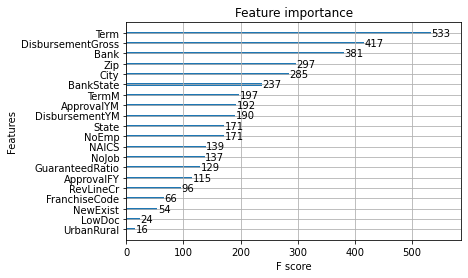

In [11]:
df = load_df() 
les, df, x_train, x_test, y_train, y_test = data_pipe_line(df)
f1, acc = experiment(df, x_train, x_test, y_train, y_test)

<font color='black'> Model Evaluation</font>

In [12]:
def scoring_of_models(f1, acc):
    
    model_names = ['KNN', 'LR', 'DT', 'RF', 'GBM', 'MLP', 'XGB', 'LGBM','CATBoost']
    accuracy_record = pd.DataFrame({'Model': model_names, 'acc': acc})
    accuracy_record['acc_mean'] = accuracy_record.mean(axis=1).round(2)
    accuracy_record.set_index('Model', inplace=True)
    accuracy_record.loc['avg'] = accuracy_record.mean()

    F1_record = pd.DataFrame({'Model': model_names, 'f1': f1})
    F1_record['F1_mean'] = F1_record.mean(axis=1).round(2)
    F1_record.set_index('Model', inplace=True)
    F1_record.loc['avg'] = F1_record.mean()

    print(accuracy_record)
    print('\n')
    print(F1_record)

scoring_of_models(f1, acc)

                acc   acc_mean
Model                         
KNN       68.290000  68.290000
LR        71.980000  71.980000
DT        89.190000  89.190000
RF        92.560000  92.560000
GBM       91.940000  91.940000
MLP       81.590000  81.590000
XGB       93.450000  93.450000
LGBM      93.140000  93.140000
CATBoost  93.280000  93.280000
avg       86.157778  86.157778


                 f1    F1_mean
Model                         
KNN       68.280000  68.280000
LR        71.760000  71.760000
DT        89.190000  89.190000
RF        92.560000  92.560000
GBM       91.940000  91.940000
MLP       81.400000  81.400000
XGB       93.450000  93.450000
LGBM      93.140000  93.140000
CATBoost  93.280000  93.280000
avg       86.111111  86.111111


# <font color='gris'> Model Fine Tune</font>
<font color='black'>XGboost Fine tune</font>

In [13]:
"""
######## random search on XGboost, it takes hours to search. If you want check the outcome, please uncommon and run###########

def display_scores(scores):
    print("Scores: {0}\nMean: {1:.3f}\nStd: {2:.3f}".format(scores, np.mean(scores), np.std(scores)))

def report_best_scores(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
            

###### Hyperparameter search ######
df = load_df()
les, df,_,_,_,_ = data_pipe_line(df,finetune = True)
x = df.drop(columns='ChargeOff')
y = df['ChargeOff']
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=SEED)

params = {
    "colsample_bytree": uniform(0.9, 0.1),
    "colsample_bylevel": uniform(0.9, 0.1), 
    "colsample_bynode": uniform(0.9, 0.1),
    "gamma": uniform(0.4, 0.1),
    "learning_rate": uniform(0.2, 0.1),
    "max_depth": randint(5, 9),
    "n_estimators": randint(120, 170),
    "subsample": uniform(0.9, 0.1),
    "reg_lambda": uniform(1, 1),
    "reg_alpha": uniform(0, 1)
}

search = RandomizedSearchCV(xgb_model,
                            param_distributions=params,
                            random_state=SEED,
                            n_iter=100, scoring='accuracy',
                            cv=10, verbose=1,
                            n_jobs=-1, return_train_score=True)

search.fit(x, y)

report_best_scores(search.cv_results_, 1)

"""

'\n######## random search on XGboost, it takes hours to search. If you want check the outcome, please uncommon and run###########\n\ndef display_scores(scores):\n    print("Scores: {0}\nMean: {1:.3f}\nStd: {2:.3f}".format(scores, np.mean(scores), np.std(scores)))\n\ndef report_best_scores(results, n_top=3):\n    for i in range(1, n_top + 1):\n        candidates = np.flatnonzero(results[\'rank_test_score\'] == i)\n        for candidate in candidates:\n            print("Model with rank: {0}".format(i))\n            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(\n                  results[\'mean_test_score\'][candidate],\n                  results[\'std_test_score\'][candidate]))\n            print("Parameters: {0}".format(results[\'params\'][candidate]))\n            print("")\n            \n\n###### Hyperparameter search ######\ndf = load_df()\nles, df,_,_,_,_ = data_pipe_line(df,finetune = True)\nx = df.drop(columns=\'ChargeOff\')\ny = df[\'ChargeOff\']\nxgb_model = xgb

Final search outcome:  
{'colsample_bylevel': 0.9250242898164596, 'colsample_bynode': 0.9549226664706121, 'colsample_bytree': 0.9714595922700062, 'gamma': 0.4660197376717732, 'learning_rate': 0.2279933896945943, 'max_depth': 8, 'n_estimators': 158, 'reg_alpha': 0.6571113285001668, 'reg_lambda': 1.435672898677891, 'subsample': 0.9730039316561818}

In [14]:
def fine_tune_xgboost():
    df = load_df()
    
    les, df, x_train, x_test, y_train, y_test = data_pipe_line(df, finetune = True) #open fine tune for transformation
    
    params = {'colsample_bylevel': 0.9250242898164596, 
          'colsample_bynode': 0.9549226664706121,
          'colsample_bytree': 0.9714595922700062, 
          'gamma': 0.4660197376717732, 
          'learning_rate': 0.2279933896945943, 
          'max_depth': 8,
          'n_estimators': 158,
          'reg_alpha': 0.6571113285001668,
          'reg_lambda': 1.435672898677891,
          'subsample': 0.9730039316561818}

    classifier = xgb.XGBClassifier(objective="binary:logistic", **params, random_state=SEED)
    classifier.fit(x_train, y_train)
    y_pred = classifier.predict(x_test)
    acc, f1 = metrics(y_pred, y_test)
    print(f'acc: {acc}, f1:{f1}')
    
fine_tune_xgboost()

acc: 93.46, f1:93.46


<font color='black'>MLP Fine tune</font>

In [15]:
def fine_tune_MLP():
    
    df = load_df()
    
    les, df, x_train, x_test, y_train, y_test = data_pipe_line(df, ss = True)

    classifier = MLPClassifier((32,8), activation='tanh', random_state=SEED)
    
    classifier.fit(x_train, y_train)
    
    y_pred = classifier.predict(x_test)
    
    acc, f1 = metrics(y_pred, y_test)
    
    print(f'acc: {acc}, f1:{f1}')
    
fine_tune_MLP()

acc: 90.72, f1:90.72


# <font color='gris'> Final submission</font>

In [16]:
def load_xtest(les, finetune = False, ss = False, cat= False):
    
    xtest_df = pd.read_csv(os.path.join(GCS_DS_PATH, Xtest_PATH))
    id_col = xtest_df['Id'].values
    
    if cat:
        xtest_df = fill_nan_categorical(xtest_df)
        xtest_df['City'][pd.isnull(xtest_df['City'])]  = 'NaN'
        xtest_df['State'][pd.isnull(xtest_df['State'])]  = 'NaN'
        xtest_df = fill_nan_continuous(xtest_df)
        xtest_df = transform(xtest_df)
        xtest_df.drop(columns='index', inplace=True)
        
        return xtest_df, id_col 
    
    xtest_df = encode_with_le(xtest_df, *les)
    xtest_df = fill_nan_continuous(xtest_df)
    xtest_df = transform(xtest_df,  finetune = finetune)
    xtest_df.drop(columns='index', inplace=True)
    if ss:
        SS = StandardScaler()
        xtest_df.loc[:,:] = SS.fit_transform(xtest_df)
    return xtest_df, id_col 

<font color='black'>XGboost Submission: 0.93842 public leaderboard score</font>

In [17]:
def make_xgboost_submission():
    df = load_df()
    les, df,_,_,_,_ = data_pipe_line(df,finetune = True)
    x = df.drop(columns='ChargeOff')
    y = df['ChargeOff']
    
    params = {'colsample_bylevel': 0.9250242898164596, 
          'colsample_bynode': 0.9549226664706121,
          'colsample_bytree': 0.9714595922700062, 
          'gamma': 0.4660197376717732, 
          'learning_rate': 0.2279933896945943, 
          'max_depth': 8,
          'n_estimators': 158,
          'reg_alpha': 0.6571113285001668,
          'reg_lambda': 1.435672898677891,
          'subsample': 0.9730039316561818}

    classifier = xgb.XGBClassifier(objective="binary:logistic", **params, random_state=SEED)
    classifier.fit(x, y)
    xtest_df, id_col  = load_xtest(les, finetune = True)
    # model
    res = classifier.predict(xtest_df)
    submission_df = pd.DataFrame({"Id": id_col,
                          "ChargeOff": res})
    submission_df.head()
    submission_df.to_csv('submission_XGB.csv', index=False)
    print('make_xgboost_submission done')
    return res, id_col
make_xgboost_submission()

make_xgboost_submission done


(array([1, 0, 1, ..., 0, 0, 1]),
 array([    0,     1,     2, ..., 99997, 99998, 99999]))

<font color='black'>Model ensemble majority voting of XGB, CatBoosting, MLP</font>

In [18]:
def MLP_predict():
    df = load_df()
    
    les, df, _, _, _, _ = data_pipe_line(df, ss = True)

    classifier = MLPClassifier((32,8), activation='tanh', random_state=SEED)
    
    x = df.drop(columns='ChargeOff')
    
    y = df['ChargeOff']
    
    classifier.fit(x, y)
    
    xtest_df, id_col   = load_xtest(les, ss = True)
    res = classifier.predict(xtest_df)
    print('MLP_predict done')
    return res
MLP_predict()

MLP_predict done


array([1, 0, 0, ..., 0, 0, 1])

<font color='black'>CATboost Submission: 0.93727 public leaderboard score</font>

In [19]:
def CatBoosting_predict():
    df = load_df()
    
    df, _, _, _, _ = data_pip_line_for_CATBOOST(df)

    classifier = cb.CatBoostClassifier(random_state=SEED)
    
    x = df.drop(columns='ChargeOff')
    
    y = df['ChargeOff']
    
    categorical_features_indices = np.where(x.dtypes != np.float)[0]
        
    classifier.fit(x, y, cat_features=categorical_features_indices, silent= True)
    
    xtest_df, id_col   = load_xtest(les, cat = True)
    
    res = classifier.predict(xtest_df)
    print('CatBoosting_predict done')
    return res
CatBoosting_predict()

CatBoosting_predict done


array([1, 0, 1, ..., 0, 0, 1])

![](http://)<font color='black'>Majority voting XGB, MLP, Catboost</font>

In [20]:
res_XG , id_col= make_xgboost_submission()
res_MLP = MLP_predict()
res_Cat = CatBoosting_predict()
final = []
for i in range(len(res_XG)):
    if res_XG[i] + res_MLP[i] + res_Cat[i] >= 2:
        final.append(1)
    else:
        final.append(0)
submission_df = pd.DataFrame({"Id": id_col,
                      "ChargeOff": np.array(final)})
submission_df.head()
submission_df.to_csv('submission_majority_XG_MLP_Cat.csv', index=False)
print('XG MLP Cat majority voting done')

make_xgboost_submission done
MLP_predict done
CatBoosting_predict done
XG MLP Cat majority voting done


In [21]:
def lgbm_predict():
    df = load_df()
    les, df,_,_,_,_ = data_pipe_line(df,finetune = True)
    x = df.drop(columns='ChargeOff')
    y = df['ChargeOff']

    classifier = lgbm.LGBMClassifier(objective="binary", random_state=SEED)
    classifier.fit(x, y)
    xtest_df, id_col  = load_xtest(les, finetune = True)
    # model
    res = classifier.predict(xtest_df)
    print('lgbm_predict done')
    return res
make_xgboost_submission()

make_xgboost_submission done


(array([1, 0, 1, ..., 0, 0, 1]),
 array([    0,     1,     2, ..., 99997, 99998, 99999]))

![](http://)<font color='black'>Majority voting XGB, LGBM, Catboost</font>

In [22]:
res_XG, id_col = make_xgboost_submission()
res_lgbm = lgbm_predict()
res_Cat = CatBoosting_predict()
final = []
for i in range(len(res_XG)):
    if res_XG[i] + res_lgbm[i] + res_Cat[i] >= 2:
        final.append(1)
    else:
        final.append(0)
submission_df = pd.DataFrame({"Id": id_col,
                      "ChargeOff": np.array(final)})
submission_df.head()
submission_df.to_csv('submission_majority_lgbm_xg_cat.csv', index=False)
print('XG lgbm Cat majority voting done')

make_xgboost_submission done
lgbm_predict done
CatBoosting_predict done
XG lgbm Cat majority voting done
